In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

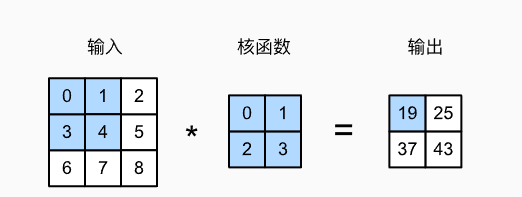

注：输出的卷积层有时被称为特征映射（feature map）

感受野： 在卷积神经网络中，对于某一层的任意元素，其感受野（receptive field）是指在前向传播期间可能影响x计算的所有元素（来自所有先前层）。比如19的感受野就是输入的蓝色的四个元素

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])

corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [4]:
# 卷积层
# 卷积层中的两个被训练的参数是卷积核权重和标量偏置
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))    

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [5]:
# 图像中目标的边缘检测（卷积层的一个简单应用）
# 首先构造一个6 * 8的黑白图像，中间四列为黑（0）
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
# 构造一个高度为1，宽度为2的卷积核k
K = torch.tensor([[1.0, -1.0]])

In [8]:
Y = corr2d(X, K)
Y  # 1代表从白色到黑色边缘

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [9]:
# 现在将输入的二维图像转置，再进行如上互相关运算
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [10]:
# 证明该卷积核K只能检测垂直边缘，无法检测水平边缘

In [11]:
# 学习卷积核
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)  # 输入和输出通道数都是1，简单起见，忽略偏置

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度）
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 12.416
epoch 4, loss 4.314
epoch 6, loss 1.638
epoch 8, loss 0.649
epoch 10, loss 0.262


In [13]:
conv2d.weight.data.reshape((1, 2))  # 很接近之前定义的

tensor([[ 1.0433, -0.9381]])

In [ ]:
# 对于卷积核张量上的权重，我们称其为“元素”